In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(12345)

Lecture notes: https://tamarabroderick.com/ml.html

# Hyperplanes

Hyperplane through origin:
$$\theta \cdot x = 0$$

plot:
$$x_2 = -\frac{\theta_1}{\theta_2}\cdot x_1$$

Generic hyperplanes (not through origin unless $\theta_0 = 0$): 
$$\theta \cdot x + \theta_0 = 0$$

Plotting equation in 2d:
$$x_2 = -\frac{\theta_0 + \theta_1x_1}{\theta_2}$$

unit normal vector, perpendicular to the plane:
$$ \hat\theta = \frac{\theta}{\lVert{\theta}\rVert}$$

\theta: [-0.54532796 -0.36648332]


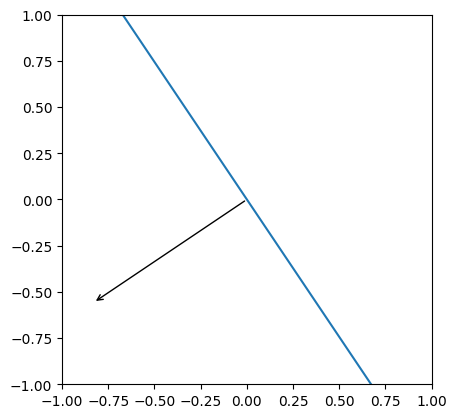

In [2]:
theta = rng.uniform(-1,1, size=2)

print(f"\\theta: {theta}")

x1 = np.linspace(-5, 5)
x2 = - theta[0]/theta[1] * x1

theta_norm = np.sqrt(np.sum(theta**2))

plt.plot(x1,x2)
plt.annotate("", xy=theta/theta_norm, xytext=(0, 0),
             arrowprops=dict(arrowstyle="->"))
plt.axis([-1, 1, -1, 1])
plt.gca().set_aspect('equal', 'box');

# (Signed) Point to hyperplane distance

Let w be a vector between plane and p:
$$ w = p - x, $$
where $x$ is defined by our equation.

Our distance $D$ is then a distance of projection vector pr of $w$ onto $\theta$, given by:
$$ \mathrm{pr}_{\theta} = \frac{w \cdot \theta}{\theta \cdot \theta}\theta$$
Substituting our $w$:
$$ \mathrm{pr}_{\theta} = \frac{(p - x)\cdot\theta}{\theta \cdot \theta}\theta = \frac{p \cdot \theta - x \cdot \theta}{\theta \cdot \theta}\theta$$
using definition of a plane $\theta\cdot x+\theta_0=0$:
$$ \mathrm{pr}_{\theta} = \frac{p \cdot \theta + \theta_0}{\theta \cdot \theta}\theta$$

Since $\mathrm{pr}$ is parallel to $\theta$, we can get its distance by multiplying it by a unit $\hat\theta$ vector (recall that $\mathrm{pr}_{\theta} \cdot \hat\theta = \lVert\mathrm{pr}_\theta\rVert\cdot1\cdot \cos(\alpha) = \lVert\mathrm{pr}_\theta\rVert$). Then:

$$ D = \lVert\mathrm{pr}_{\theta}\rVert = \mathrm{pr}_{\theta} \cdot \hat\theta = \mathrm{pr}_{\theta} \cdot \frac{\theta}{\lVert\theta\rVert} = \frac{p \cdot \theta + \theta_0}{\theta \cdot \theta}\theta \cdot \frac{\theta}{\lVert\theta\rVert} = \frac{p \cdot \theta + \theta_0}{\lVert\theta\rVert},$$
which is the distance we were looking for.

Distance is positive if $p$ is on the same side where $\theta$ is pointing to, and negative if it's on the other side.

If $\theta$ is normalized (or we don't care about units too much) the distance equation becomes simpler:
$$D = p \cdot \theta + \theta_0$$

![point-plane](https://introml_oll.odl.mit.edu/cat-soop/_static/6.036/homework/hw01/example3.png)

\theta: [0.59473091 0.35250934]


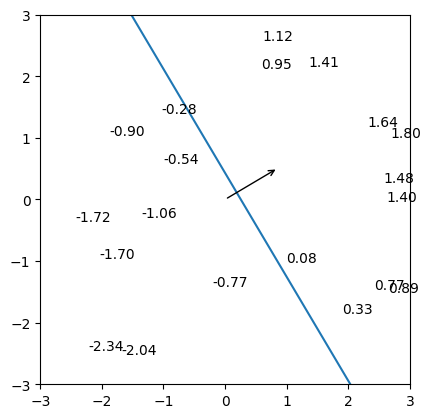

In [3]:
N_points = 20
bounds = 3

theta = rng.uniform(-1,1, size=2)
theta_0 = rng.uniform(-.7,.7)

print(f"\\theta: {theta}")

x1 = np.linspace(-5, 5)
x2 = - (theta_0 + theta[0]*x1)/theta[1]

theta_norm = np.sqrt(np.sum(theta**2))

plt.plot(x1,x2)
plt.annotate("", xy=theta/theta_norm, xytext=(0, 0),
             arrowprops=dict(arrowstyle="->"))


X = rng.uniform(-bounds,bounds, size=(N_points, 2))
for p in X:
    dist = p@theta + theta_0
    plt.text(p[0], p[1], f"{dist:.2f}")


plt.axis([-bounds, bounds, -bounds, bounds])
plt.gca().set_aspect('equal', 'box');

# Logistic regression

Logistic (sigmoid) function:

$$ \sigma(z) = \frac{1}{1 + \exp\left(-z\right)}$$

maps $z$ onto a range of $(0, 1)$ values.

In linear regression we assign a real value $\hat y$ to each observation $x_i$ by computing $\theta \cdot x + \theta_0$. Geometrically this corresponds to computing distance $D$ between point $x_i$ and hyperplane $\theta \cdot x + \theta_0$.

In logistic regression we use sigmoid function to linearly transform these distances into probabilities that a data point $x_i$ belongs to a certain class:

$$ P(x_i = 1) = g(x_i) = \sigma(\theta \cdot x_i + \theta_0), $$

where $P(x_i=1)$ is my super sloppy notation that should be read as probability that observation $x_i$ has label $y_i = 1$. We want our function $g(x_i)$ ($g$ for guess) to maximize $P(x_i=1)$ whenever $y_i=1$ and to maximize $1-P(x_i=1)$ whenever $y_i \neq 1$. In other words, we want to maximize probability of the correct labels, and do it over the whole dataset $P(X = y)$. Since individual probabilities we assign don't influence each other, on the dataset level

$$P(X=y) = \prod_i P(x_i = y_i)$$

Taking care of situations when $y_i \neq 1$ we get:

$$P(X = y) = \prod_i \left[ g(x_i)^{y_i}\cdot (1-g(x_i))^{1-y_i} \right]$$

The above expression works as numbers in 0-th power are just once.

Since probabilities get really small really fast, instead of working on maximizing $P$ we can instead minimze $\log(P)$, expressed as:

$$L = - \log(P(X=y)) = - \sum_i y_i \log\left[g(x_i)\right] + (1-y_i)\log\left[1-g(x_i)\right],$$

where the above expression is what is frequently used as a loss in binary logistic regression.

In order to minimize this loss we need to compute its derivative with respect to parameters $\Theta=(\theta, \theta_0)$

In [4]:
import statsmodels.api as sm

## Reference implementation

In [5]:
df_train = (
    pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")
    .assign(sex=lambda df: (df.Sex=='male').astype(int))
)

In [6]:
df = df_train[['Pclass','sex','Age','SibSp','Fare','Survived']].dropna()
X = df[['Pclass','sex','Age','SibSp','Fare']]
y = df['Survived']

In [7]:
model = sm.Logit(y, sm.add_constant(X))

res = model.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.445424
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      708
Method:                           MLE   Df Model:                            5
Date:                Tue, 21 Feb 2023   Pseudo R-squ.:                  0.3405
Time:                        16:35:59   Log-Likelihood:                -318.03
converged:                       True   LL-Null:                       -482.26
Covariance Type:            nonrobust   LLR p-value:                 7.608e-69
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3899      0.603      8.940      0.000       4.208       6.571
Pclass        -1.2542      0.161     -7.775      0.000      -1.570      -0.938
sex           -2.6131      0.215    -12.160      0.000      -3.034      -2.192
Age           -0.0439      0.008     -5.372      0.000      -0.060      -0.028
SibSp         -0.3924      0.123     -3.187      0.001      -0.634      -0.151
Fare           0.0019      0.002      0.784      0.433      -0.003       0.007
==============================================================================
"""

## My implementation

In [8]:
class LogisticRegression:
    def __init__(self, eta=.01, iterations=100):
        self.eta = eta
        self.iterations = iterations
    
    def _guess(self, X, theta):
        return 1/(1 + np.exp(-X@theta))
    
    def _add_constant(self, X):
        return np.c_[X, np.ones(len(X))]
    
    def fit(self, X, y):
        """ref: https://www.baeldung.com/cs/gradient-descent-logistic-regression"""
        feature_means = np.mean(X, axis=0)
        feature_stds = np.std(X, axis=0)

        X_norm = (X - feature_means) / feature_stds
        X_norm = self._add_constant(X_norm)        
        theta_i = np.random.normal(size=X_norm.shape[1])
        
        for i in range(self.iterations):
            g = self._guess(X_norm, theta_i)
            grad = (X_norm*((g - y).reshape(-1, 1))).mean(axis=0)
            theta_i = theta_i - self.eta * grad
        
        self.theta_norm = theta_i
        self.theta = self.theta_norm.copy()
        self.theta[:-1] = self.theta[:-1]/feature_stds
        self.theta[-1] = self.theta_norm[-1]-np.sum(feature_means/feature_stds*self.theta_norm[:-1])
        
    def predict(self, X):
        X = self._add_constant(X)
        return self._guess(X, self.theta)

In [9]:
lreg = LogisticRegression(iterations=1000,eta=1)
lreg.fit(X.values, y.values)
lreg.theta

array([-1.25415528e+00, -2.61310104e+00, -4.39233169e-02, -3.92416329e-01,
        1.87044698e-03,  5.38985766e+00])

In [25]:
res.params

const     5.389858
Pclass   -1.254155
sex      -2.613101
Age      -0.043923
SibSp    -0.392416
Fare      0.001870
dtype: float64

In [30]:
from sklearn.metrics import roc_curve, classification_report

In [67]:
idxmin = np.argmin(np.sqrt(fpr**2+(1-tpr)**2))
thr[idxmin], fpr[idxmin], tpr[idxmin]

(0.4321686415818197, 0.1792452830188679, 0.7724137931034483)

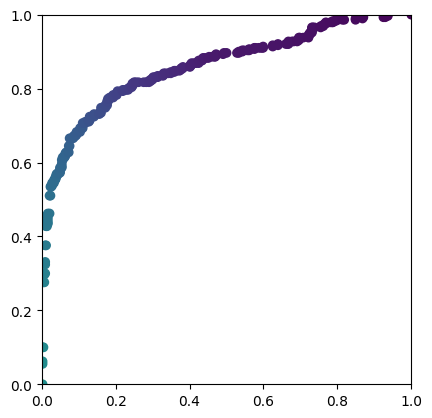

In [66]:
fpr, tpr, thr = roc_curve(y, lreg.predict(X.values))
plt.scatter(fpr, tpr, c=thr)

plt.axis([0,1,0,1])
plt.gca().set_aspect('equal', 'box');

In [52]:
print(classification_report(y, lreg.predict(X.values)>0.432))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       424
           1       0.75      0.77      0.76       290

    accuracy                           0.80       714
   macro avg       0.79      0.80      0.79       714
weighted avg       0.80      0.80      0.80       714



In [24]:
lreg.predict(X.values) - res.predict(sm.add_constant(X.values))

array([ 1.66533454e-16, -1.11022302e-16,  1.11022302e-16, -1.11022302e-16,
        1.80411242e-16,  2.77555756e-16,  1.94289029e-16,  2.22044605e-16,
       -2.22044605e-16, -1.11022302e-16, -2.22044605e-16,  2.22044605e-16,
        1.17961196e-16,  1.11022302e-16,  2.22044605e-16,  1.38777878e-16,
        5.55111512e-16,  2.77555756e-16,  1.94289029e-16, -1.11022302e-16,
       -2.22044605e-16,  1.11022302e-16,  2.77555756e-16,  5.55111512e-16,
       -1.66533454e-16,  2.49800181e-16,  1.11022302e-16,  1.66533454e-16,
        2.49800181e-16,  4.44089210e-16,  1.11022302e-16,  3.88578059e-16,
       -1.11022302e-16, -2.22044605e-16,  0.00000000e+00,  2.22044605e-16,
        2.77555756e-16,  2.77555756e-16,  0.00000000e+00,  0.00000000e+00,
        2.22044605e-16, -2.22044605e-16,  1.94289029e-16, -1.11022302e-16,
        1.45716772e-16,  1.94289029e-16, -2.22044605e-16,  4.44089210e-16,
        2.35922393e-16, -1.11022302e-16,  2.49800181e-16,  4.44089210e-16,
        9.02056208e-17,  